# 

# Homework 2 - Gravity
### Introduction to Global Geophysics - Spring 2025

Briefly describe the GOCE and GRACE satellite systems based on the materials on https://earth.esa.int/eogateway/missions/goce/description and https://www2.csr.utexas.edu/grace/GRACE_Edu_Poster/page_03.pdf

- GRACE and GOCE represent two distinct approaches to measuring Earth's gravity field. GRACE operates by using two satellites spaced 220km apart, employing a microwave ranging system to detect even the minimal distance variations between them with micron-level accuracy, with precise GPS ensures exact positioning of these measurements. In contrast, GOCE took a different approach, operating at an extremely low orbit of 250 km to capture stronger gravitational signals. It featured a distinctive arrow-shaped design without moving parts and utilized an Electrostatic Gravity Gradiometer (EGG) as its primary instrument. Due to its challenging low-orbit environment, GOCE required a special ion propulsion system to maintain its position and compensate for atmospheric drag, though this resulted in a limited operational time of 20 months.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.special import sph_harm
import os

In [40]:
main_dir = os.getcwd()
if not os.path.exists(os.path.join(main_dir, 'outputs')):
    os.makedirs(os.path.join(main_dir, 'outputs'))
out_dir = os.path.join(main_dir, 'outputs')

In [41]:
ggfm_file = 'WHU-SWPU-GOGR2022S.gfc'
n_max = 60  # Degree of the spherical harmonic expansion

C = {}
S = {}

with open(os.path.join(main_dir, ggfm_file), 'r') as f:
    for line in f:
        if line.startswith("gfc"):
            parts = line.split()
            n = int(parts[1])
            m = int(parts[2])
            if n <= n_max:
                Cnm = float(parts[3])
                Snm = float(parts[4])
                C[(n, m)] = Cnm
                S[(n, m)] = Snm

$$
\Delta g(r, \theta, \phi)=\frac{G M}{r^2} \sum_{n=2}^N(n-1)\left(\frac{R}{r}\right)^n \sum_{m=0}^n P_{n m}(\cos \theta)\left(C_{n m} \cos m \phi+S_{n m} \sin m \phi\right)
$$

Since Radial-dependence is already included in the coefficients and what needs to be plotted is a normalized gravity anomaly, we can simplify the equation to:

$$
\Delta g(r, \theta, \phi)= \sum_{n=2}^N(n-1) \sum_{m=0}^n P_{n m}(\cos \theta)\left(C_{n m} \cos m \phi+S_{n m} \sin m \phi\right)
$$

In [43]:
def delta_g_single_point(theta, phi, C, S, nmax=10):
    """
    Compute gravity anomaly at colatitude=theta, longitude=phi
    using sph_harm from SciPy and the stored Stokes coefficients C, S.

    Parameters
    ----------
    theta : float (radians), colatitude
    phi   : float (radians), longitude
    C, S  : dicts of Stokes coefficients
    nmax  : int, maximum degree

    Returns
    -------
    delta_g : float
        Gravity anomaly at this point (in m/s^2 if used with GM/R^2).
    """
    val_sum = 0.0
    for n in range(3, nmax+1):
        for m in range(0, n+1):
            # Spherical harmonic for degree n, order m
            Ynm = sph_harm(m, n, phi, theta)  # complex

            # Real part ~ P_n^m(cosθ) cos(mφ)
            # Imag part ~ P_n^m(cosθ) sin(mφ)
            Cnm = C.get((n, m), 0.0)
            Snm = S.get((n, m), 0.0)
            

            # Add the combination: C_{nm}*Re(Ynm) + S_{nm}*Im(Ynm)
            val_sum += (n - 1) * (Cnm * Ynm.real + Snm * Ynm.imag) # (R/r)^n, was omitted here because exercise said we took as already included the radial-dependent.

    delta_g_val = val_sum # I did not multiply by GM/R^2, because it is normalized gravity anomally
    return delta_g_val

In [66]:
# Define lat/lon arrays
step = 0.5  # Step size in degrees for the grid
lat_vals = np.arange(-90, 90+1, step)
lon_vals = np.arange(-180, 180+1, step)

# Prepare a 2D array for the anomaly
delta_g_map_1 = np.zeros((len(lat_vals), len(lon_vals)))

for i, lat in enumerate(lat_vals):
    # colatitude in radians:
    theta = np.radians(90.0 - lat)
    for j, lon in enumerate(lon_vals):
        phi = np.radians(lon + 180.0) 
        # Calculate anomaly at this grid point
        delta_g_map_1[i, j] = delta_g_single_point(theta, phi, C, S, nmax=10)

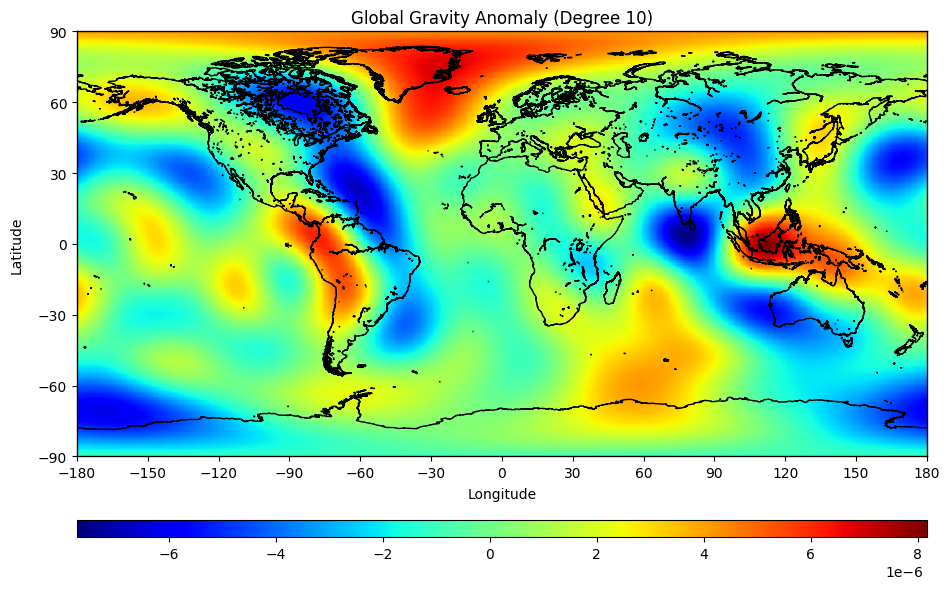

In [69]:
map = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='i')
# map = Basemap(projection='robin', lon_0=0, resolution='i')

lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals) 

x, y = map(lon_grid, lat_grid)  

fig = plt.figure(figsize=(12,6)) 

map.drawcoastlines() 
map.drawmapboundary()  

cs = map.pcolormesh(x, y, delta_g_map_1, cmap='jet', shading='auto')

cbar = map.colorbar(cs, location='bottom', pad="15%", size="4%", extend='both', extendfrac='auto', extendrect=True)
plt.title(f'Global Gravity Anomaly (Degree {10})')
plt.xlabel('Longitude', labelpad=5)
plt.ylabel('Latitude', labelpad=10) 
#show ticks and labels 
plt.xticks(np.arange(-180, 181, 30))  # Longitude ticks at 30-degree intervals
plt.yticks(np.arange(-90, 91, 30))    # Latitude ticks at 30-degree intervals

plt.tight_layout()  

plt.savefig(os.path.join(out_dir, f'global_gravity_anomaly_{10}.png'))
plt.show() 

In [47]:
# Define lat/lon arrays
n_max = 60  
step = 0.5  # Step size in degrees for the grid
lat_vals = np.arange(-90, 90+1, step)
lon_vals = np.arange(-180, 180+1, step)

# Prepare a 2D array for the anomaly
delta_g_map = np.zeros((len(lat_vals), len(lon_vals)))

for i, lat in enumerate(lat_vals):
    # colatitude in radians:
    theta = np.radians(90.0 - lat)
    for j, lon in enumerate(lon_vals):
        phi = np.radians(lon + 180.0) 
        # Calculate anomaly at this grid point
        delta_g_map[i, j] = delta_g_single_point(theta, phi, C, S, nmax=60)

In [51]:
print(delta_g_map)

[[-5.31236539e-06 -5.31236539e-06 -5.31236539e-06 ... -5.31236539e-06
  -5.31236539e-06 -5.31236539e-06]
 [-4.46226446e-06 -4.45621848e-06 -4.45023359e-06 ... -4.46837075e-06
  -4.46226446e-06 -4.45621848e-06]
 [-3.19610519e-06 -3.18207035e-06 -3.16819221e-06 ... -3.21029472e-06
  -3.19610519e-06 -3.18207035e-06]
 ...
 [ 2.14708412e-06  2.14871835e-06  2.15036647e-06 ...  2.14546412e-06
   2.14708412e-06  2.14871835e-06]
 [ 2.36594865e-06  2.36594865e-06  2.36594865e-06 ...  2.36594865e-06
   2.36594865e-06  2.36594865e-06]
 [ 2.14708412e-06  2.14871835e-06  2.15036647e-06 ...  2.14546412e-06
   2.14708412e-06  2.14871835e-06]]


In [50]:
# save data to file

delta_g_map.tofile(os.path.join(out_dir, 'global_gravity_anomaly_60.dat'))

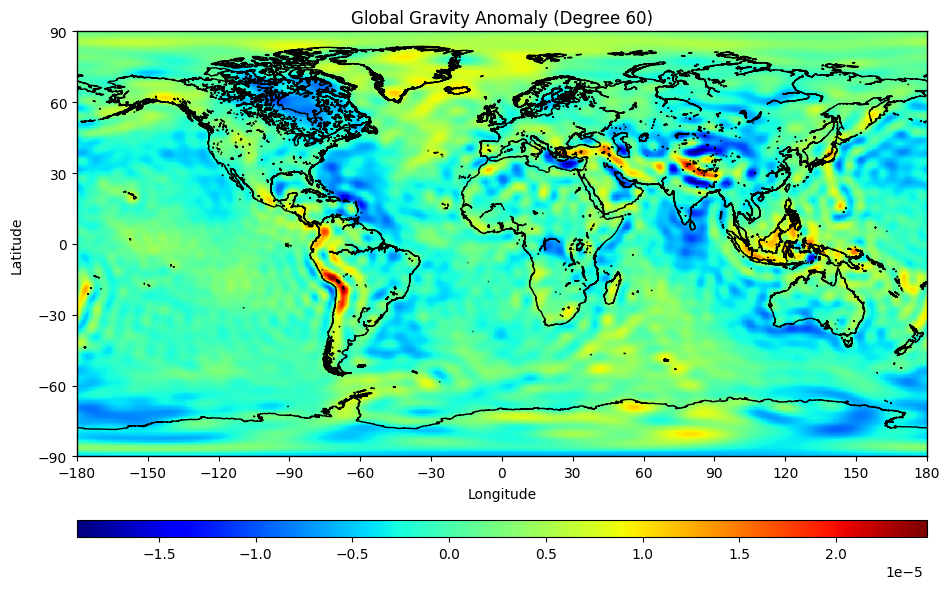

In [64]:
map = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='i')
#map = Basemap(projection='robin', lon_0=0, resolution='i')

lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals) 

x, y = map(lon_grid, lat_grid)  

fig = plt.figure(figsize=(12,6)) 

map.drawcoastlines() 
map.drawmapboundary()  

cs = map.pcolormesh(x, y, delta_g_map, cmap='jet', shading='auto')

cbar = map.colorbar(cs, location='bottom', pad="15%", size="4%", extend='both', extendfrac='auto', extendrect=True)
plt.title(f'Global Gravity Anomaly (Degree {60})')
plt.xlabel('Longitude', labelpad=5)
plt.ylabel('Latitude', labelpad=10) 
#show ticks and labels 
plt.xticks(np.arange(-180, 181, 30))  # Longitude ticks at 30-degree intervals
plt.yticks(np.arange(-90, 91, 30))    # Latitude ticks at 30-degree intervals

plt.tight_layout()  

plt.savefig(os.path.join(out_dir, f'global_gravity_anomaly_{60}.png'))
plt.show() 

## Comparison between 10 degrees and 60 degrees spherical harmonics global gravity anomaly maps

If I compare the 10 degrees and 60 degrees spherical harmonics global gravity anomaly maps, I can see that the 60 degrees map has more detailed, both maps are calculated using the same data and a grid of 0.5 degrees. But the one for 60 degrees shows a smoother pattern where we can see a stronger correlation between the positive anomalies and major topographic features, like the Himalayas and the Andes, this could imply that the 60 degrees map is representing more the influence of topography on gravity. 
For the 10 degrees map, the pattern is less detailed and more generalized, with less correlation between the positive anomalies and major topographic features, but there is correlation between the big subduction zones and the positive anomalies, this could imply that the 10 degrees map is representing more the influence of more deep structures on gravity. So the 10 degrees map emphasizes larger-scale features by minimizing the influence of surface topography, while the 60 degrees map captures more detailed or smaller-scale variations in the gravity field.

For (d) point I put the results in the folder `homework2_gravity` in the repository, there you can finde `requestgeoid.png` that is the parameters I used for the request of the geoid data and the results of the request showed in the web GUI are shown in `resultsgeoid.png`. The raw data is also there in geotiff format and xyz ASCII format.